# Retail Giant Sales Forecasting Assignment
by **Sai Vamsy Dhulipala**

## Problem Statement

**Global Mart** is an **online supergiant store** that has **worldwide operations**. This store caters to **7 different geographical market segments** and **3 major customer segments**, i.e. **consumer, corporate and home office**.

**Due to certain unpredictable circumstances** in the market, the company is **prioritizing** only the **best and most consistent market segment** in terms of profitability. It is required to **forecast the sales of the products for the next 6 months** for the **most consistently profitable market segment**.

## Data Preperation

### Importing libraries

**Importing libraries for data analysis**

In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth",100)

**Importing libraries for data visualisation**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

**Importing libraries for time series analysis**

In [3]:
from scipy.stats import variation
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import boxcox

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [4]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

**Suppressing warnings**

In [5]:
from warnings import filterwarnings
filterwarnings("ignore")

### Importing and inspecting the dataset

**Importing the dataset**

In [6]:
data = pd.read_csv("Global+Superstore+Data.csv")

data.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


**Understanding the shape and structure**

In [7]:
data.shape

(51290, 5)

In [8]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 10.2 MB


**<span style = "color:green">We find that no columns have missing values present. Hence, there is no need for futher imputation.</span>**

**<span style = "color:green">Yet, we find that `Order Date` has to be converted to `DateTime` and has to be made the `index` of the dataframe.</span>**

**Converting `Order Date` to `DateTime` and setting it as the `index`**

In [9]:
data["Order Date"] = pd.to_datetime(data["Order Date"],format="%d-%m-%Y")
data.sort_values("Order Date",ascending=True,inplace=True)
data.set_index("Order Date",inplace=True,drop=True)

data.head()

,Segment,Market,Sales,Profit
Order Date,,,,
2011-01-01,Consumer,EMEA,66.120,29.640
2011-01-01,Consumer,APAC,120.366,36.036
2011-01-01,Consumer,Africa,408.300,106.140
2011-01-01,Consumer,APAC,55.242,15.342
2011-01-01,Home Office,EU,44.865,-26.055


## Identification of the best and consistently profitable market segment

**<span style = "color:green">Now that the step of initial data preperation is complete, the following steps have to be undertaken in order to compute the `Coefficient of Variation (CoV)` for each market segment:</span>**

- **<span style = "color:green">Aggregating the `daily sales data` to the `monthly sales data` for each market segment.</span>**

- **<span style = "color:green">Splitting the data into `train` and `test` by considering `42 months` as `train data` and balance `6 months` as `test data`.</span>**

- **<span style = "color:green">Converting the `Order Date` from `date-time` format to `month-year` format.</span>**

**Preparing the data as described above**

In [10]:
train = pd.DataFrame()
test = pd.DataFrame()

for market in data["Market"].unique():
    
    for segment in data["Segment"].unique():
        
        df = data[(data["Market"]==market)&(data["Segment"]==segment)].resample("MS").sum().round(2)
        
        df["Market Segment"] = market + " - " + segment
        df = df[["Market Segment","Sales","Profit"]]
        
        train = pd.concat([train,df.iloc[:42]],axis=0)
        test = pd.concat([test,df.iloc[42:]],axis=0)

train.set_index(train.index.to_period(freq="M"),inplace=True)
test.set_index(test.index.to_period(freq="M"),inplace=True)

In [11]:
train.head()

,Market Segment,Sales,Profit
Order Date,,,
2011-01,EMEA - Consumer,2790.46,-2099.36
2011-02,EMEA - Consumer,1287.51,267.06
2011-03,EMEA - Consumer,9696.11,1598.72
2011-04,EMEA - Consumer,1769.00,-300.88
2011-05,EMEA - Consumer,3716.59,568.30


In [12]:
test.head()

,Market Segment,Sales,Profit
Order Date,,,
2014-07,EMEA - Consumer,8847.91,-144.95
2014-08,EMEA - Consumer,15716.87,2232.02
2014-09,EMEA - Consumer,19674.02,2770.46
2014-10,EMEA - Consumer,8789.81,588.74
2014-11,EMEA - Consumer,12748.06,1237.90


**Computing Coefficient of Variation (CoV) on train data**

**<span style = "color:green">The Coefficient of Variation is a statistical measure of the dispersion of data points around the mean. It is commonly used to compare the data dispersion between distinct series of data. Unlike standard deviation that must always be considered in the context of the mean of the data, the coefficient of variation provides a relatively simple and quick tool to compare different data series.</span>**

**<span style = "color:green">The formula for the coefficient of variation is expressed as follows:</span>**

<span style = "color:green">$$CoV = \frac {\sigma} {\mu} \times 100$$</span>

**<span style = "color:green">For the sake of convenience, `variation` imported from `scipy.stats` package is being used to compute the Coefficient of Variation.</span>**

In [13]:
CoVs = []

for market_segment in train["Market Segment"].unique():
    
    df = train[train["Market Segment"]==market_segment]
    
    CoV = round(variation(df["Profit"].values),4)
    CoVs.append(CoV)

df_CoVs = pd.DataFrame({"Coefficient of Variation":CoVs},index=train["Market Segment"].unique())
df_CoVs.sort_values(by="Coefficient of Variation",ascending=True,inplace=True)

print(df_CoVs)

                      Coefficient of Variation
APAC - Consumer                         0.5964
EU - Consumer                           0.6475
LATAM - Consumer                        0.6807
EU - Corporate                          0.6893
APAC - Corporate                        0.7319
LATAM - Corporate                       0.8803
US - Corporate                          1.0272
APAC - Home Office                      1.0488
US - Consumer                           1.0953
EU - Home Office                        1.1147
US - Home Office                        1.2171
LATAM - Home Office                     1.3437
Africa - Consumer                       1.4293
Canada - Corporate                      1.6279
Canada - Consumer                       1.6458
Africa - Corporate                      1.6648
Africa - Home Office                    1.9899
EMEA - Consumer                         2.7170
Canada - Home Office                    3.3260
EMEA - Home Office                      6.0667
EMEA - Corpor

**<span style = "color:green">From the above results, we can find that `APAC - Consumer` market segment has the least Coefficient of Variation `0.5964`, implying that this segment has been depicting steady profitability since the last 42 months over other segments. Hence, the same market segment shall be used to forecast the sales for the next 6 months.</span>**

**Dropping the remaining market segments from train and test data**

In [14]:
train = train[train["Market Segment"]=="APAC - Consumer"]
test = test[test["Market Segment"]=="APAC - Consumer"]

test.set_index(test.index.to_timestamp(freq=None),inplace=True)
train.set_index(train.index.to_timestamp(freq=None),inplace=True)

train.drop(columns="Market Segment",inplace=True)
test.drop(columns="Market Segment",inplace=True)

## Identification of trend and seasonality in the selected market segment

**Visualising the data**

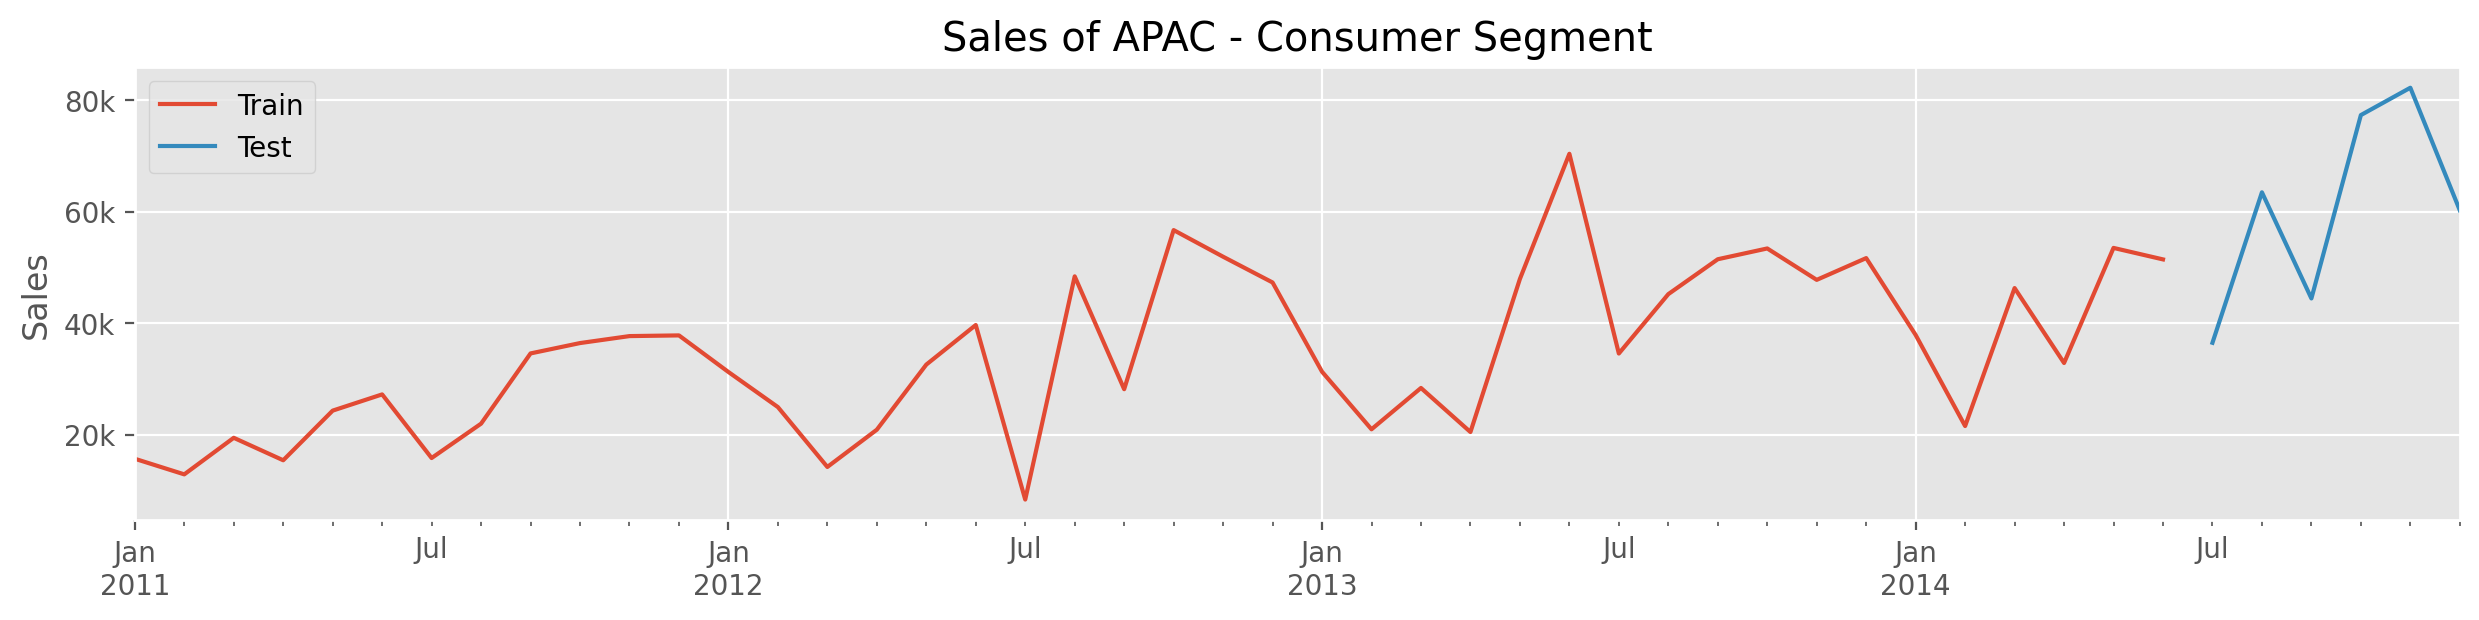

In [15]:
fig, ax = plt.subplots(figsize=(15,3),dpi=200)

train["Sales"].plot(ax=ax,legend="best",label="Train")
test["Sales"].plot(ax=ax,legend="best",label="Test")

ax.set_yticklabels([str(int(i/10**3))+"k" for i in list(ax.get_yticks())])
ax.set_xlabel("")
ax.set_ylabel("Sales")
ax.set_title("Sales of APAC - Consumer Segment")

fig.show()

**<span style = "color:green">Upon observing the above plot, we can understand that the data seems to have been following somewhat a linear trend. Also, there seems to be a lot of noise associated as the seasonality is not visible much. Since there is a linear trend in the data, Additive Seasonal Decomposition can be used to break the data further to observe the trend and seasonality.</span>**

**Using `Additive Seasonal Decomposition` to identify the trend and seasonality**

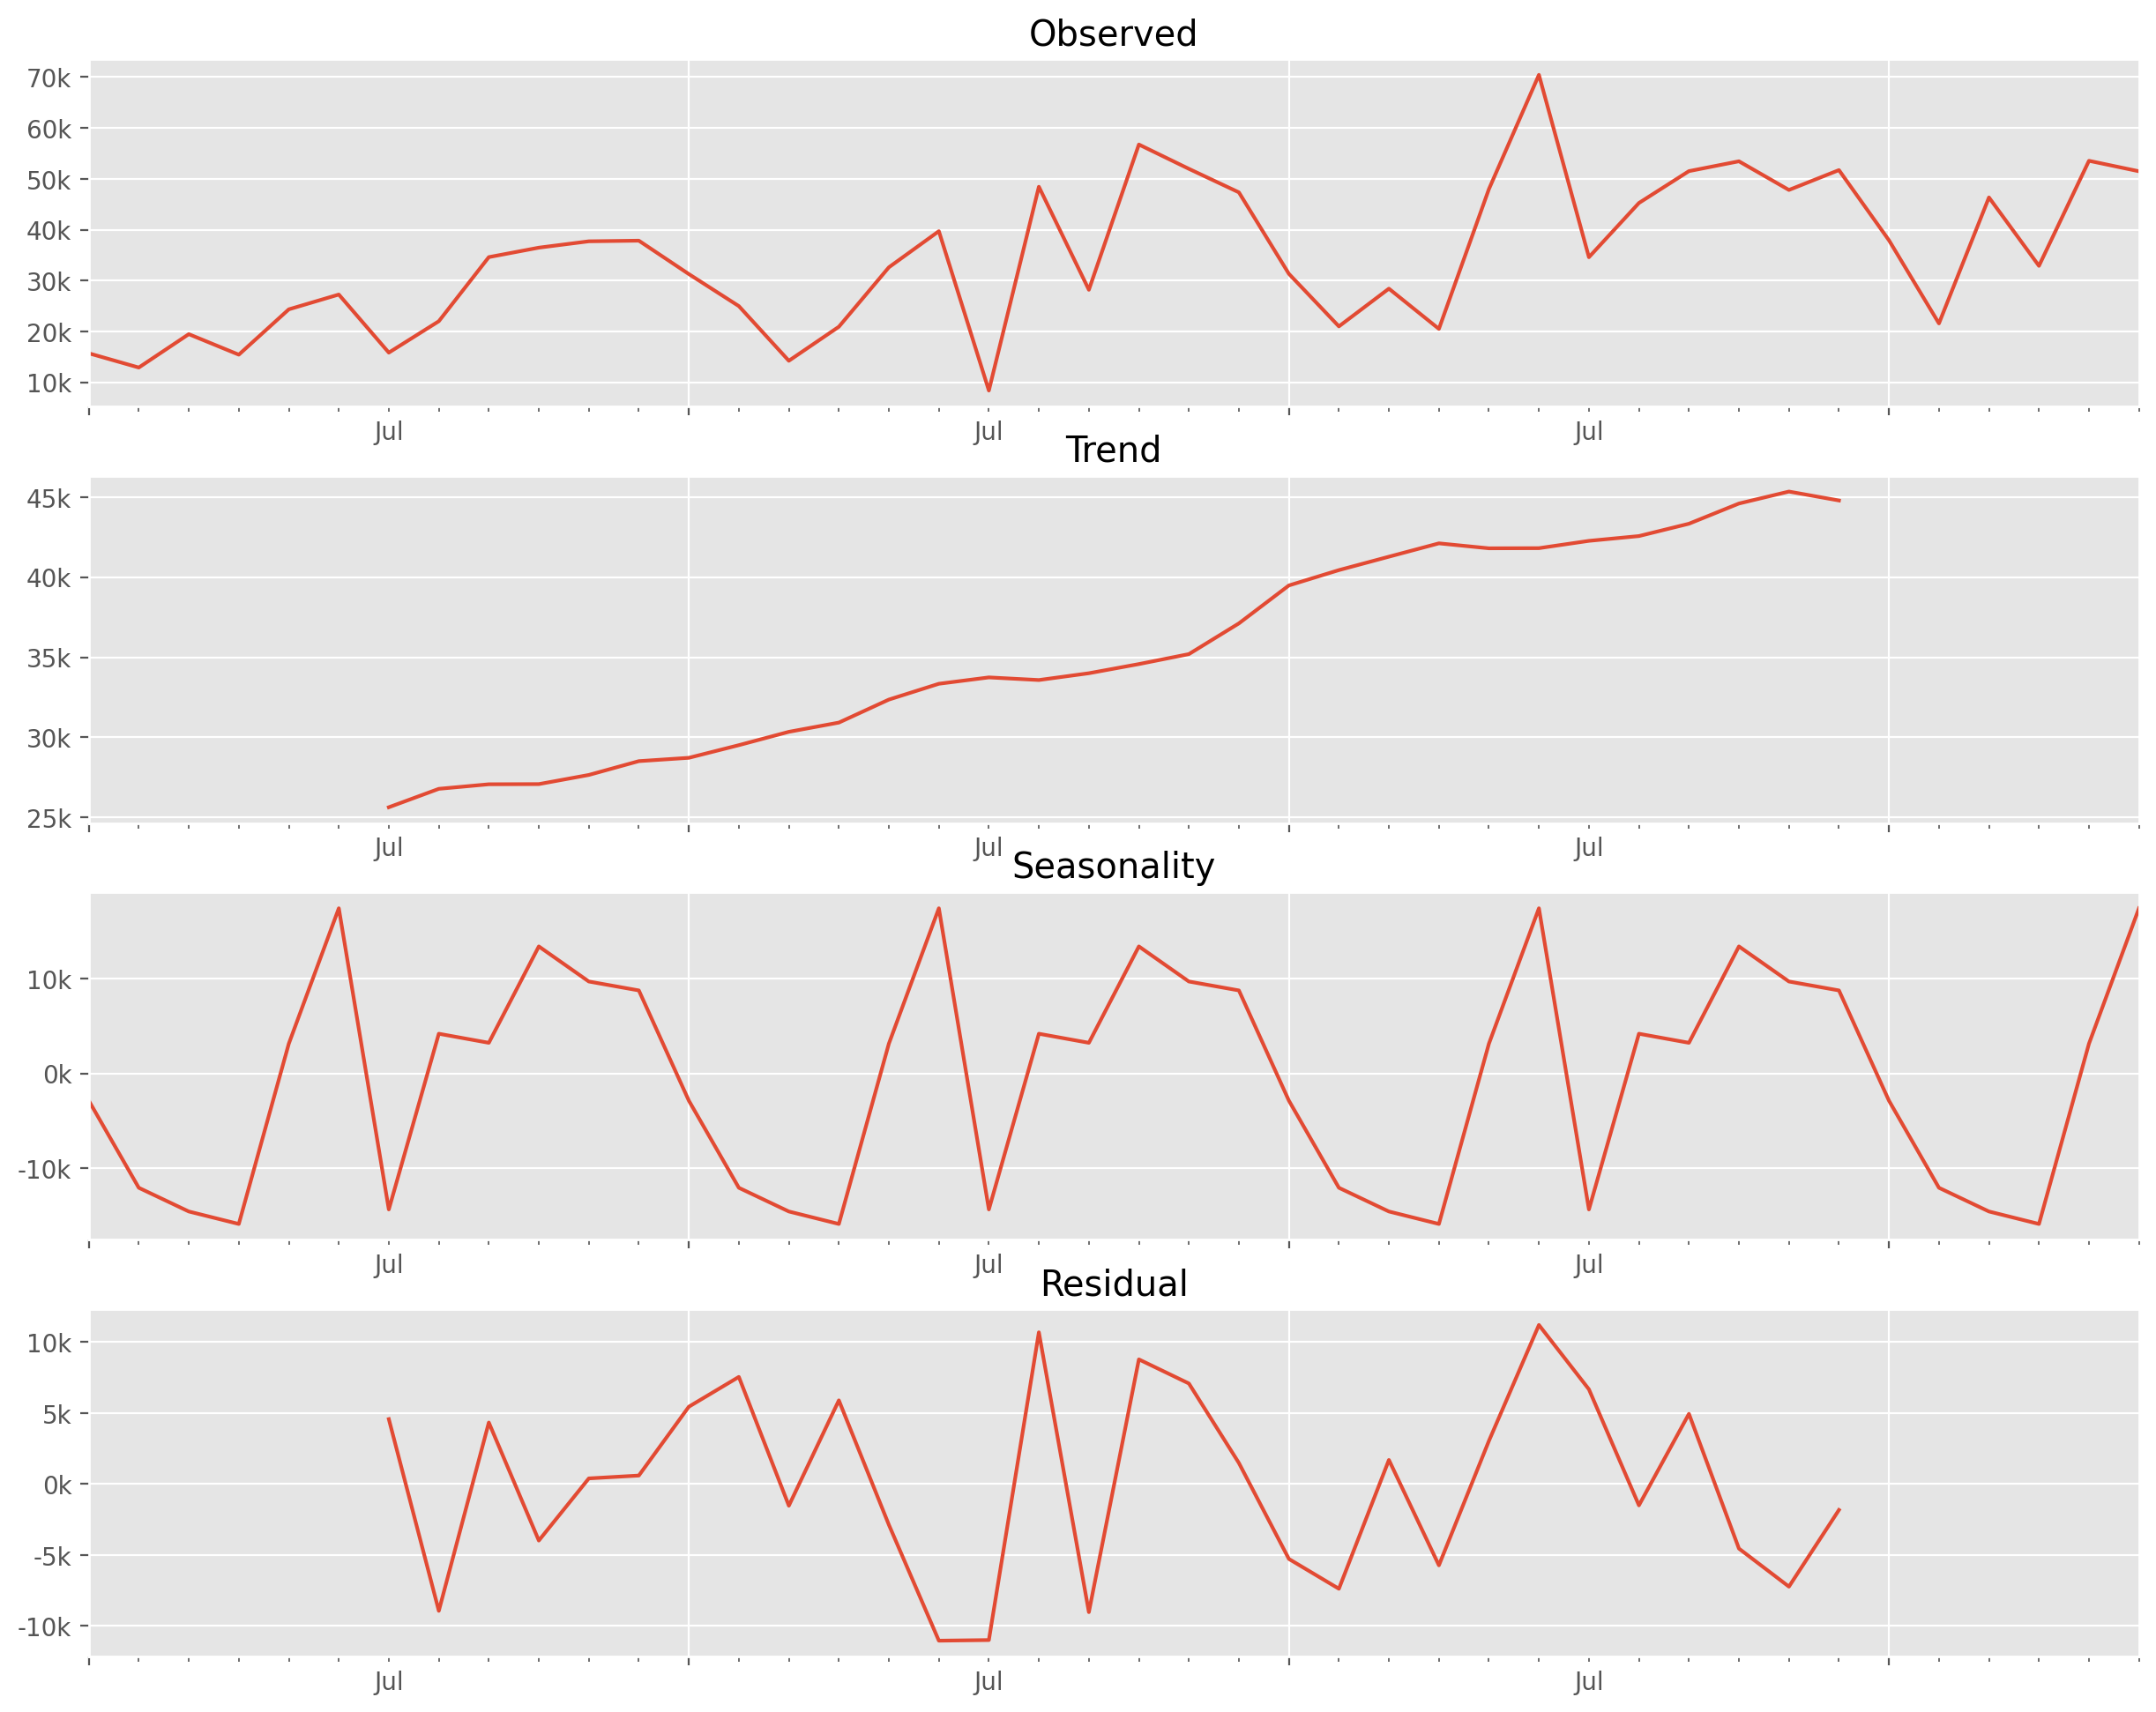

In [16]:
result = seasonal_decompose(train["Sales"], model="additive")

fig, ax = plt.subplots(4,figsize=(15,12),dpi=200)

result.observed.plot(ax=ax[0])
ax[0].set_title("Observed")
ax[0].set_xlabel("")
ax[0].set_yticklabels([str(int(i/10**3))+"k" for i in list(ax[0].get_yticks())])
ax[0].set_xticklabels([])

result.trend.plot(ax=ax[1])
ax[1].set_title("Trend")
ax[1].set_xlabel("")
ax[1].set_yticklabels([str(int(i/10**3))+"k" for i in list(ax[1].get_yticks())])
ax[1].set_xticklabels([])

result.seasonal.plot(ax=ax[2])
ax[2].set_title("Seasonality")
ax[2].set_xlabel("")
ax[2].set_yticklabels([str(int(i/10**3))+"k" for i in list(ax[2].get_yticks())])
ax[2].set_xticklabels([])

result.resid.plot(ax=ax[3])
ax[3].set_title("Residual")
ax[3].set_xlabel("")
ax[3].set_yticklabels([str(int(i/10**3))+"k" for i in list(ax[3].get_yticks())])
ax[3].set_xticklabels([])

fig.show()

**<span style = "color:green">Upon observing the above plots, we can understand that the data is following a linear trend and also has high seasonality associated. Also, the data contains a lot of white noise due to which the trend and the seasonality are not visible on the initial observation of the data.</span>**

## Identifying the right model for forecast

<img src="https://images.upgrad.com/6f4f3c18-37c9-4d03-a5e2-aa3d6e98c48b-Screenshot%20(148).png">

**<span style = "color:green">From the above flowchart, we can understand that `ARIMA` or `Exponential Smoothing` models can be applied where the `historical data contains more than 10 observations`, which is valid in our case since train data contains 42 months of historical data.</span>**

**<span style = "color:green">Further to that, in case of choosing the `Exponential Smoothing` models, we have to check whether the data is `following trend and seasonality`. Since there is a `strong evidence of both trend and seasonality`, the `best model` to choose would be the `Holt Winters' Exponential Smoothing model`.</span>**

**<span style = "color:green">While coming to `ARIMA` models, we have to choose the appropiate model based on the evidence of `seasonality` and `presence of an Exogeneous variable`. Since there is evidence of `presence of seasonality` but `no evidence of presence of Exogeneous variable`, the `best model` to choose would be `Seasonal Auto Regressive Integrated Moving Average (SARIMA)` model.</span>**

### Creating custom functions to reduce the redundancy of code

**Creating a dataframe `forecast` to store the forcast results from all the models**

In [17]:
forecast = pd.DataFrame()

**Buliding a custom function `get_mape` to get the Mean Absolute Percentage Error (MAPE) for each model**

In [18]:
def get_mape(df):    
    mapes = []

    for col in df.columns:
        
        mape = np.round(np.mean(np.abs(test["Sales"]-df[col])/test["Sales"])*100,2)
        
        mapes.append(mape)
        
    print(pd.DataFrame({"MAPE":mapes},index=df.columns.values))

**Building a custom funtion `plot_forecast` to plot the forecast results**

In [19]:
def plot_forecast(series,title):
    
    fig, ax = plt.subplots(figsize=(15,3),dpi=200)

    train["Sales"].plot(ax=ax,legend="best",label="Train")
    test["Sales"].plot(ax=ax,legend="best",label="Test")
    series.plot(ax=ax,legend="best",label="Forecast")

    ax.set_yticklabels([str(int(i/10**3))+"k" for i in list(ax.get_yticks())])
    ax.set_xlabel("")
    ax.set_ylabel("Sales")
    ax.set_title(f"Forecast using {title}")

    fig.show()

**Building a custom funtion `recover_forecast` to recover the actual forecast results (Applicable for ARIMA models)**

In [20]:
def recover_forecast(model_fit):
    fc_boxcox_diff = model_fit.predict(test.index.min(),test.index.max())
    fc_boxcox = fc_boxcox_diff.cumsum()
    fc_boxcox = fc_boxcox.add(data_boxcox[test.index.min()])
    fc = np.exp(fc_boxcox)
    return fc

## Forecasting using Exponential Smoothing models

### Forecasting using Simple Exponential Smoothing

**Fitting the model**

**<span style = "color:green">In order to obtain the best results, the parameter `optimized` has been set to `True`.</span>**

In [21]:
ses_model = SimpleExpSmoothing(train["Sales"])
ses_model_fit = ses_model.fit(optimized=True)

for key in ses_model_fit.params.keys():
    print(f"{key}: {ses_model_fit.params[key]}")

smoothing_level: 0.21419997610119915
smoothing_slope: nan
smoothing_seasonal: nan
damping_slope: nan
initial_level: 19970.643681265385
initial_slope: nan
initial_seasons: []
use_boxcox: False
lamda: None
remove_bias: False


**Getting the forecast**

In [22]:
forecast["Simple Exponential Smoothing"] = ses_model_fit.forecast(6)

**Computing MAPE**

In [23]:
get_mape(forecast)

                               MAPE
Simple Exponential Smoothing  27.73


**Plotting the forecast**

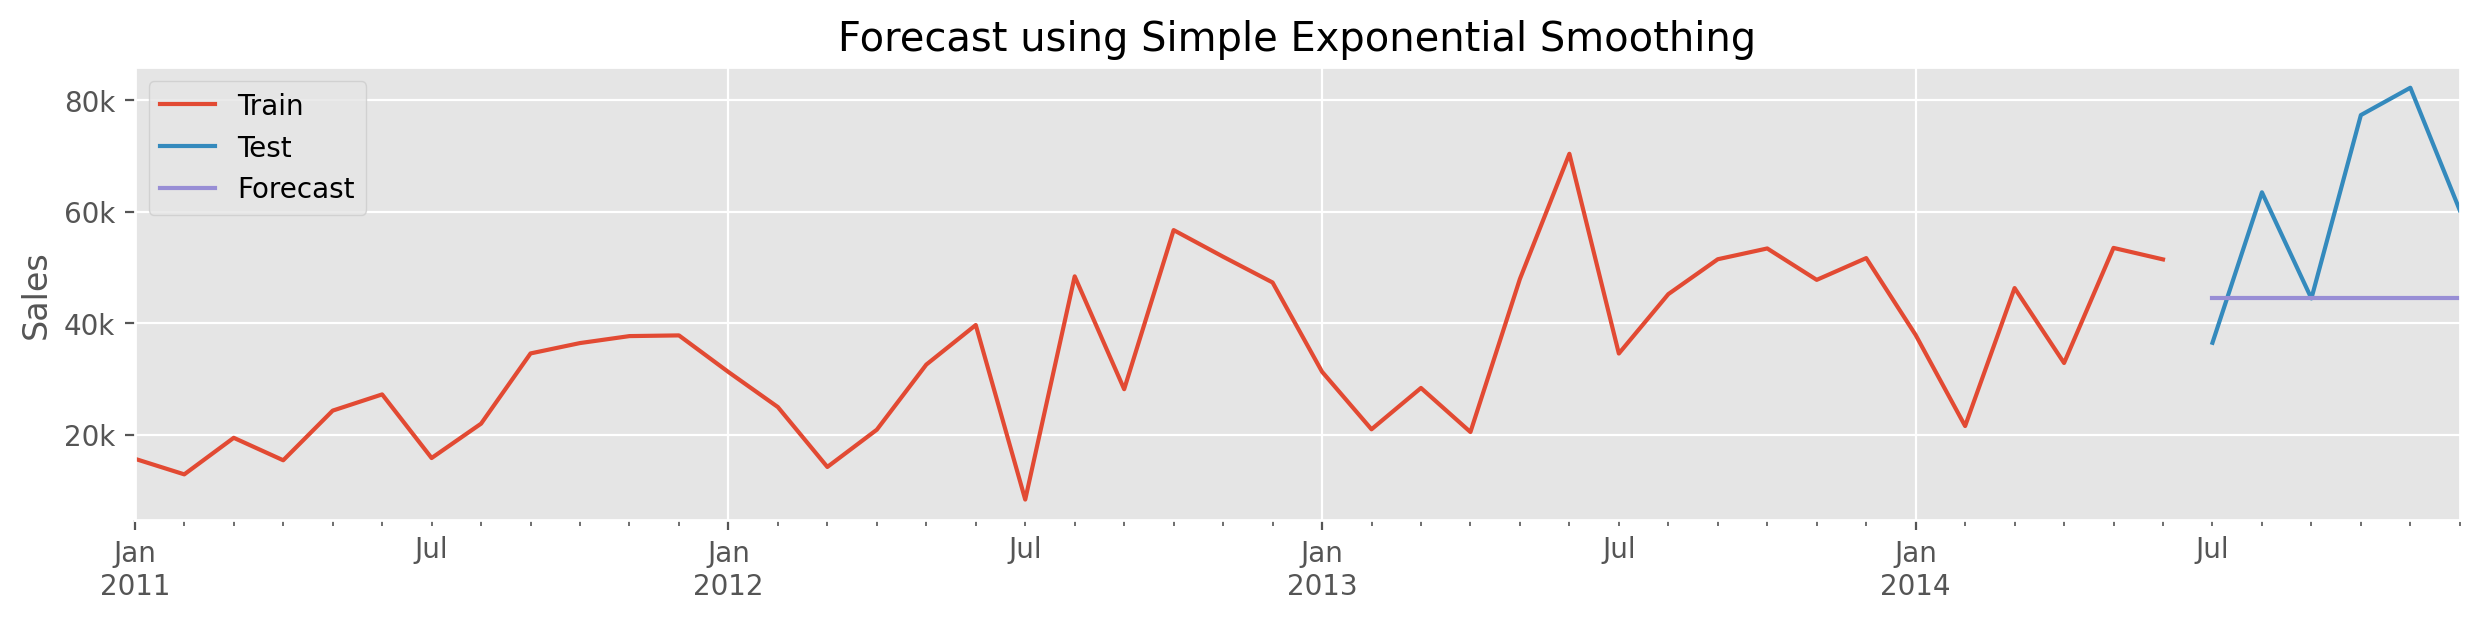

In [24]:
plot_forecast(forecast["Simple Exponential Smoothing"],"Simple Exponential Smoothing")

**<span style = "color:green">From the above plot, we can observe that the model has failed to capture both trend and seasonality. Also, the MAPE result also seems to be higher. Hence, this is not a suitable method to be used to forecast the sales for the selected market segment.</span>**

### Forecasting using Holt's Exponential Smoothing

**Fitting the model**

**<span style = "color:green">In order to obtain the best results, the parameter `optimized` has been set to `True`.</span>**

In [25]:
hes_model = ExponentialSmoothing(train["Sales"],seasonal_periods=12,trend="add",seasonal=None)
hes_model_fit = hes_model.fit(optimized=True)

for key in hes_model_fit.params.keys():
    print(f"{key}: {hes_model_fit.params[key]}")

smoothing_level: 7.355157552115235e-11
smoothing_slope: 7.047003098791156e-12
smoothing_seasonal: nan
damping_slope: nan
initial_level: 16684.0782935349
initial_slope: 802.9189509066448
initial_seasons: []
use_boxcox: False
lamda: None
remove_bias: False


**Getting the forecast**

In [26]:
forecast["Holt's Exponential Smoothing"] = hes_model_fit.forecast(6)

**Computing MAPE**

In [27]:
get_mape(forecast)

                               MAPE
Simple Exponential Smoothing  27.73
Holt's Exponential Smoothing  25.01


**Plotting the forecast**

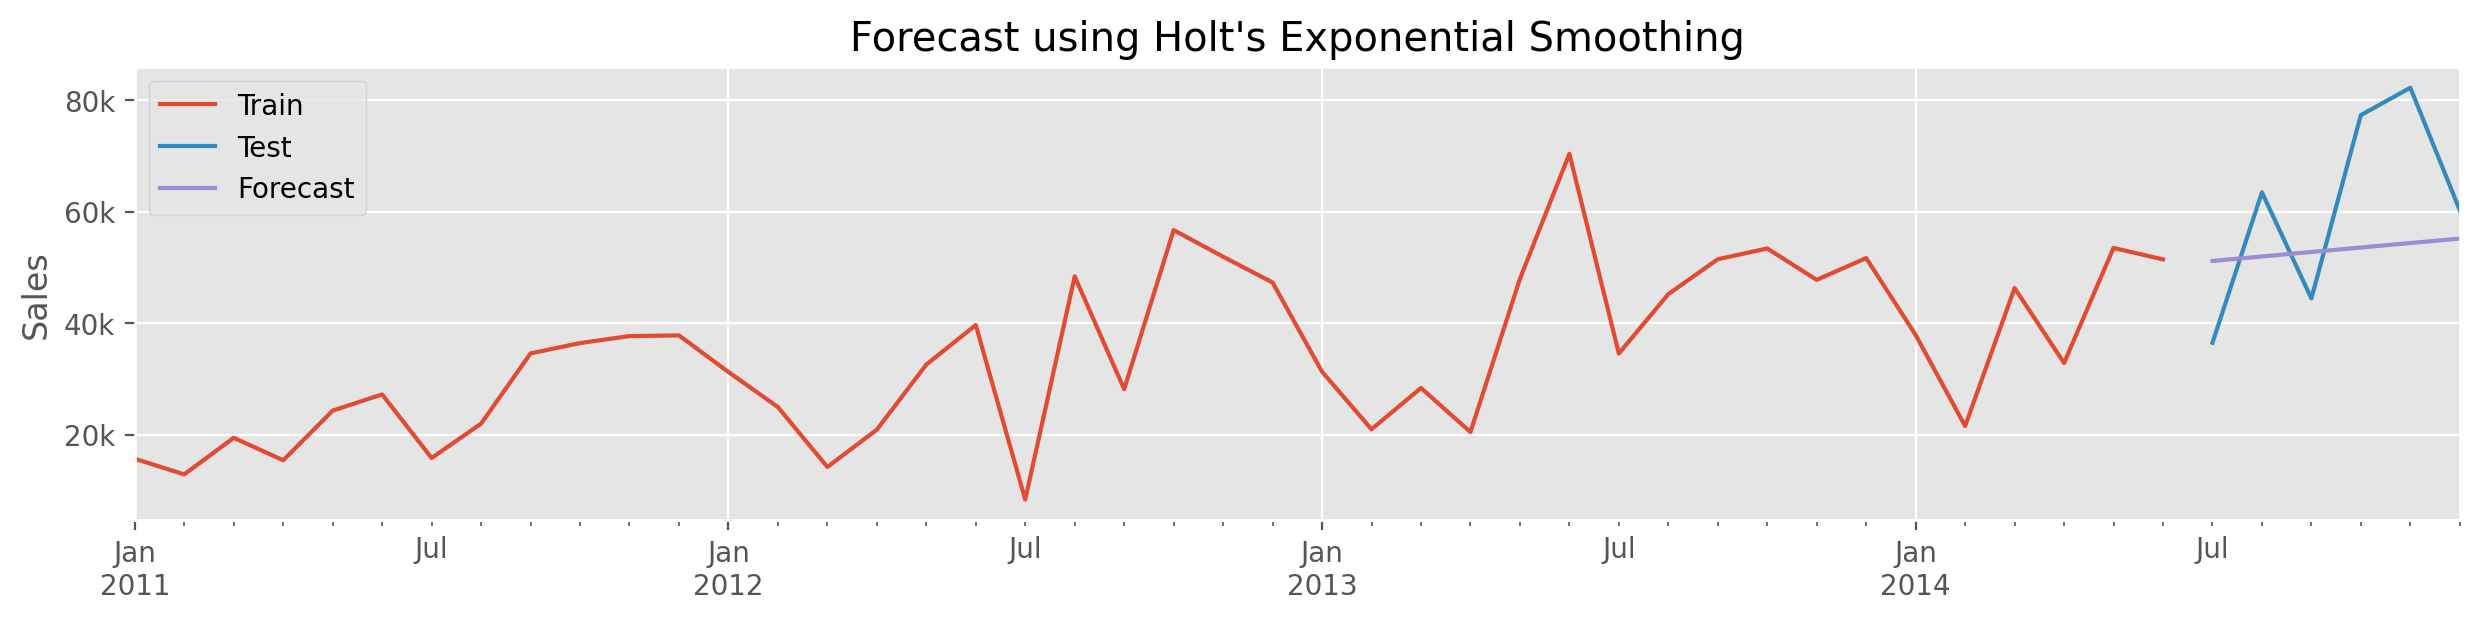

In [28]:
plot_forecast(forecast["Holt's Exponential Smoothing"],"Holt's Exponential Smoothing")

**<span style = "color:green">From the above plot, we can observe that the model has captured trend but not seasonality. Also, there is not much significant drop in the MAPE results compared to the earlier model. Hence, this is not a suitable method to be used to forecast the sales for the selected market segment.</span>**

### Forecasting using Holt Winters' Exponential Smoothing under Additive Method

**Fitting the model**

**<span style = "color:green">In order to obtain the best results, the parameter `optimized` has been set to `True`.</span>**

In [29]:
hwesa_model = ExponentialSmoothing(train["Sales"].values,seasonal_periods=12,trend="add",seasonal="add")
hwesa_model_fit = hwesa_model.fit(optimized=True)

for key in hwesa_model_fit.params.keys():
    print(f"{key}: {hwesa_model_fit.params[key]}")

smoothing_level: 0.052631578947367676
smoothing_slope: 0.05263157894736842
smoothing_seasonal: 0.10526315789474947
damping_slope: nan
initial_level: 29061.28999999959
initial_slope: 730.4168055555452
initial_seasons: [-13349.58 -16150.43  -9588.73 -13620.99  -4712.32  -1801.27 -13218.46
  -7049.05   5551.89   7410.76   8661.31   8785.7 ]
use_boxcox: False
lamda: None
remove_bias: False


**Getting the forecast**

In [30]:
forecast["Holt Winters' Exponential Smoothing - Additive"] = hwesa_model_fit.forecast(6)

**Computing MAPE**

In [31]:
get_mape(forecast)

                                                 MAPE
Simple Exponential Smoothing                    27.73
Holt's Exponential Smoothing                    25.01
Holt Winters' Exponential Smoothing - Additive  17.61


**Plotting the forecast**

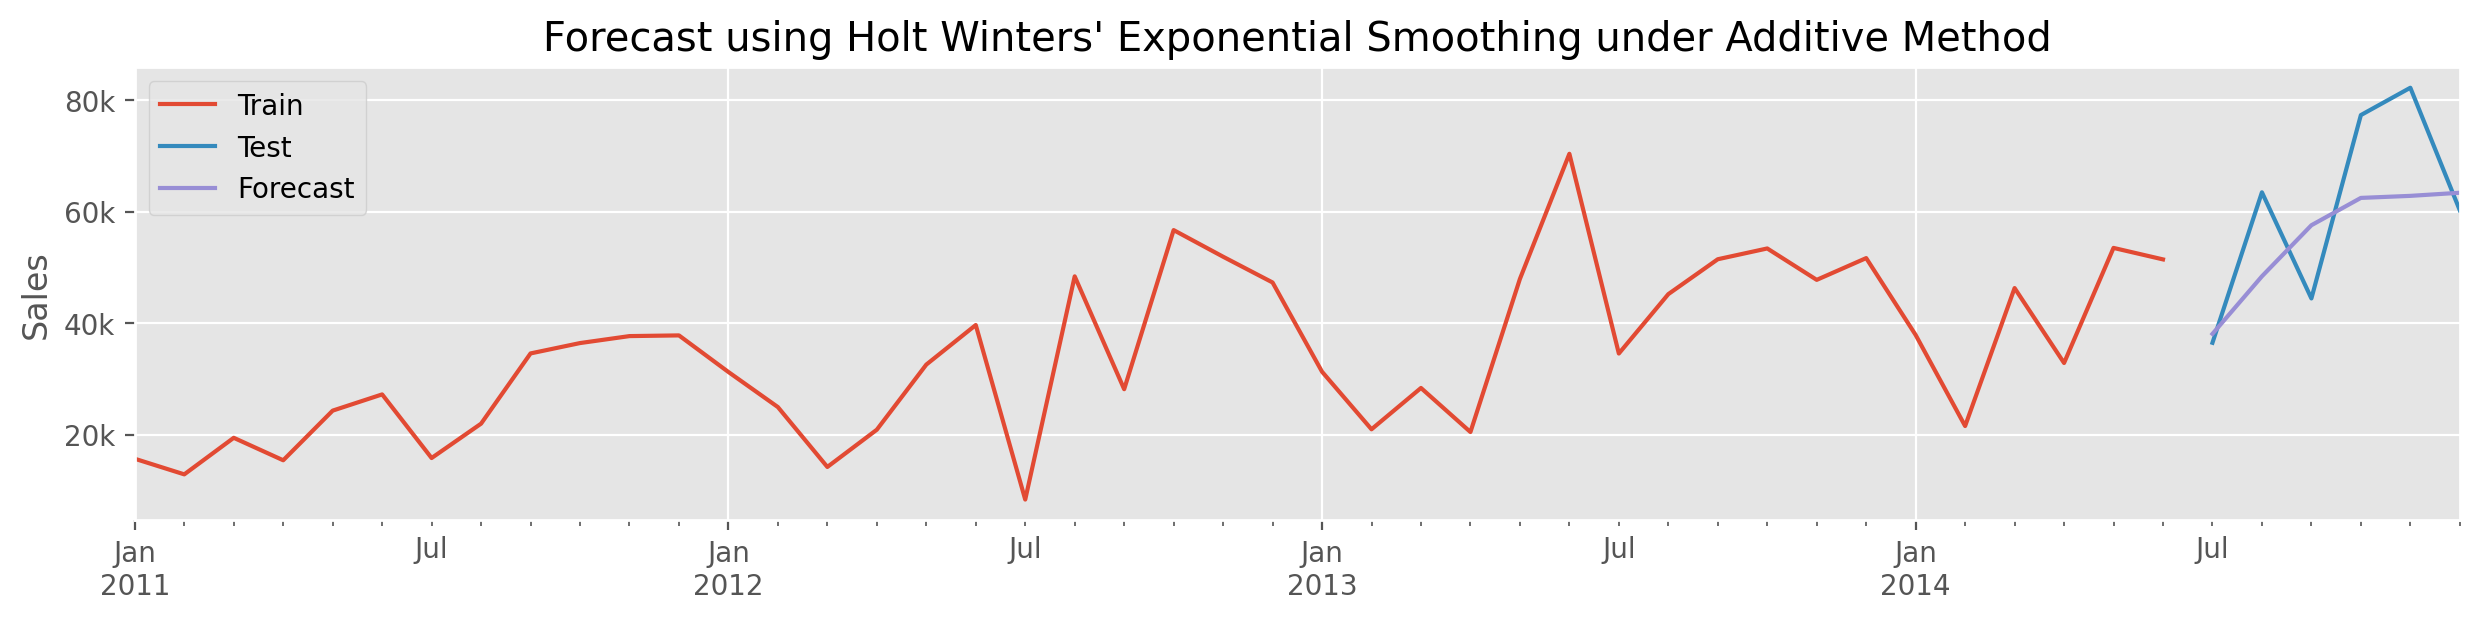

In [32]:
plot_forecast(forecast["Holt Winters' Exponential Smoothing - Additive"],
              "Holt Winters' Exponential Smoothing under Additive Method")

**<span style = "color:green">From the above plot, we can observe that the model has captured trend and also seasonality to some extent. Also, there is a significant drop in the MAPE results compared to the earlier model. Hence, this would tend to be a suitable model to be used for the forecast unless the other models perform even better.</span>**

### Forecasting using Holt Winters' Exponential Smoothing under Multiplicative Method

**Fitting the model**

**<span style = "color:green">In order to obtain the best results, the parameter `optimized` has been set to `True`.</span>**

In [33]:
hwesm_model = ExponentialSmoothing(train["Sales"].values,seasonal_periods=12,trend="mul",seasonal="mul")
hwesm_model_fit = hwesm_model.fit(optimized=True)

for key in hwesm_model_fit.params.keys():
    print(f"{key}: {hwesm_model_fit.params[key]}")

smoothing_level: 0.05263157907804813
smoothing_slope: 0.05263157893840498
smoothing_seasonal: 0.2105263158699892
damping_slope: nan
initial_level: 29061.289991705347
initial_slope: 1.025387613517913
initial_seasons: [0.7648743  0.50068989 0.74071819 0.56589709 0.99040041 1.14363002
 0.60227546 1.02140185 0.98453834 1.2103952  1.11465685 1.11634393]
use_boxcox: False
lamda: None
remove_bias: False


**Getting the forecast**

In [34]:
forecast["Holt Winters' Exponential Smoothing - Multiplicative"] = hwesm_model_fit.forecast(6)

**Computing MAPE**

In [35]:
get_mape(forecast)

                                                       MAPE
Simple Exponential Smoothing                          27.73
Holt's Exponential Smoothing                          25.01
Holt Winters' Exponential Smoothing - Additive        17.61
Holt Winters' Exponential Smoothing - Multiplicative  13.84


**Plotting the forecast**

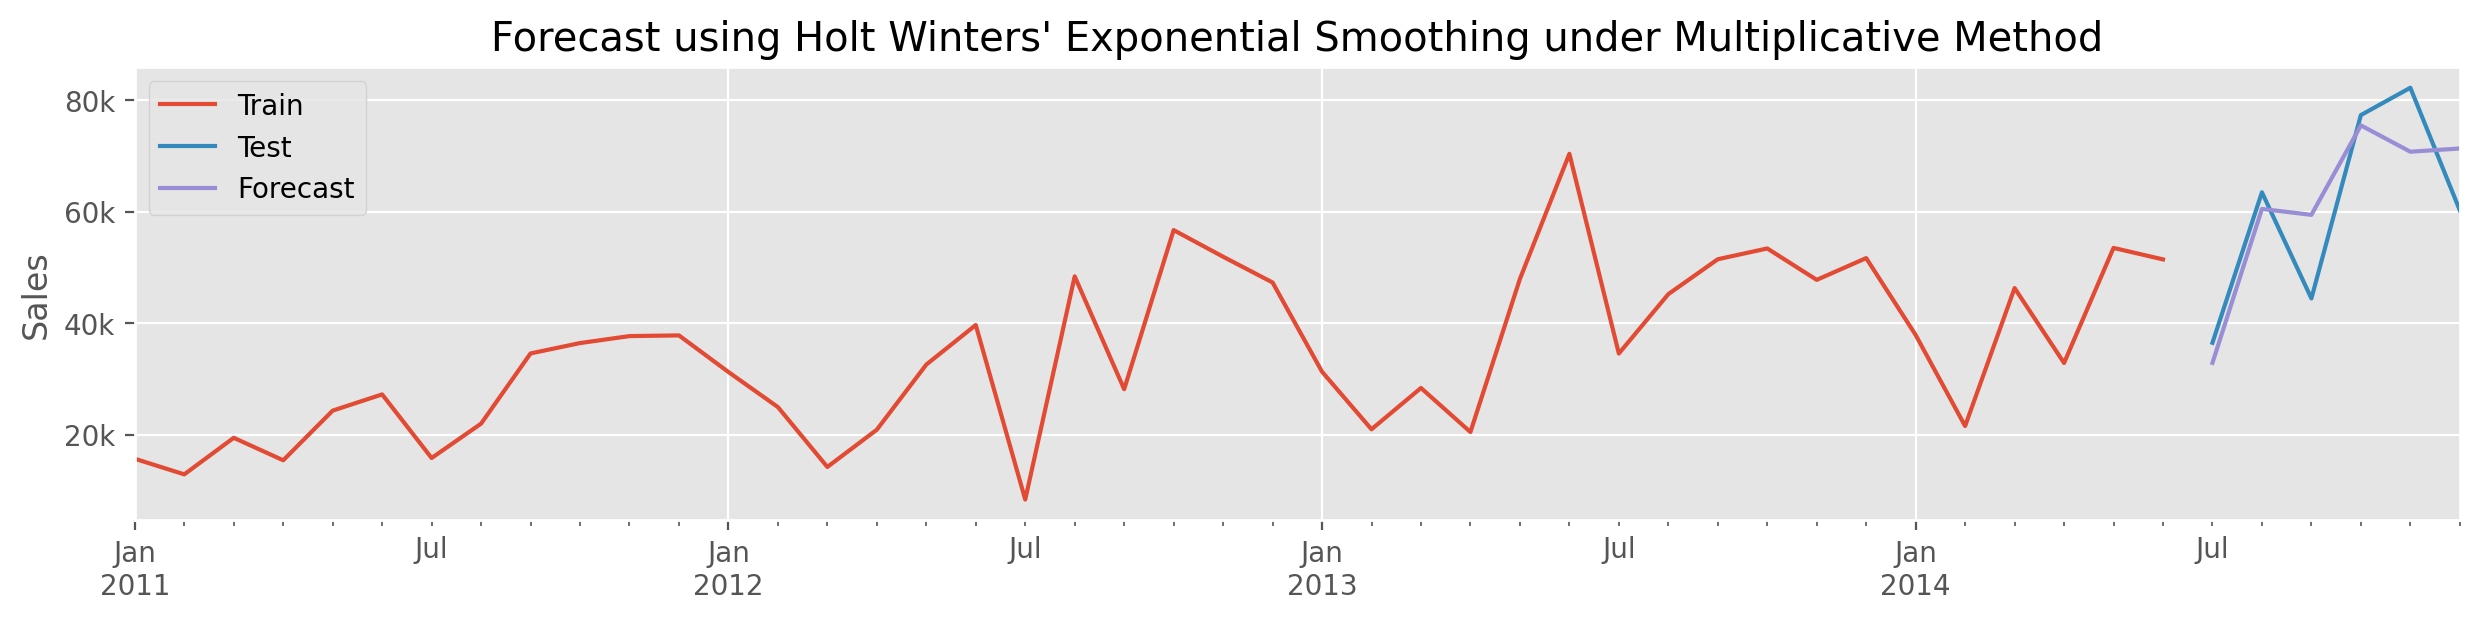

In [36]:
plot_forecast(forecast["Holt Winters' Exponential Smoothing - Multiplicative"],
              "Holt Winters' Exponential Smoothing under Multiplicative Method")

**<span style = "color:green">From the above plot, we can observe that the model has very well captured both trend and seasonality. Also, there is a significant drop in the MAPE results compared to the earlier model. Hence, this would the best model to be used for the forecast under the exponential smoothing models.</span>**

## Forecasting using ARIMA models

### Performing Stationarity Tests

**Joining both train and test data**

In [37]:
data_agg = pd.concat([train,test],axis=0)

**Performing Augmented Dickey-Fuller (ADF) Test**

**<span style = "color:green">ADF Test is a statistical test used to test whether a given time series is stationary or not.</span>**

- **<span style = "color:green">`Null Hypothesis`: The series is not stationary</span>**
    - **`p−value > 0.05`**


- **<span style = "color:green">`Alternate Hypothesis`: The series is stationary</span>**
    - **`p−value ≤ 0.05`**

In [38]:
adf_test = adfuller(data_agg["Sales"])

print(f"ADF Statistic: {round(adf_test[0],3)}")
print(f"Critical Values @ 0.05: {round(adf_test[4]['5%'],3)}")
print(f"p-value: {round(adf_test[1],3)}")

ADF Statistic: -2.221
Critical Values @ 0.05: -2.927
p-value: 0.199


**<span style = "color:green">From the above results, we `fail to reject` the `Null Hypothesis`, i.e., we `fail to reject` that the `data is not stationary`.</span>**

**Performing Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**

**<span style = "color:green">KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.</span>**

- **<span style = "color:green">`Null Hypothesis`: The series is stationary</span>**
    - **`p−value > 0.05`**


- **<span style = "color:green">`Alternate Hypothesis`: The series is not stationary</span>**
    - **`p−value ≤ 0.05`**

In [39]:
kpss_test = kpss(data_agg["Sales"])

print(f"KPSS Statistic: {round(kpss_test[0],3)}")
print(f"Critical Values @ 0.05: {round(kpss_test[3]['5%'],3)}")
print(f"p-value: {round(kpss_test[1],3)}")

KPSS Statistic: 0.596
Critical Values @ 0.05: 0.463
p-value: 0.023


**<span style = "color:green">From the above results, we `reject` the `Null Hypothesis`, i.e., we `reject` that the `data is stationary`.</span>**

### Performing Box-Cox Transformation and Differencing in order to make the data stationary

**Performing Box-Cox Transformation to make the variance constant**

In [40]:
data_boxcox = pd.Series(boxcox(data_agg["Sales"],lmbda=0),index=data_agg.index)

**Performing Differencing on the transformed data remove trend**

In [41]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(),index=data_agg.index)
data_boxcox_diff.dropna(inplace=True)

**Visualising the transformed data**

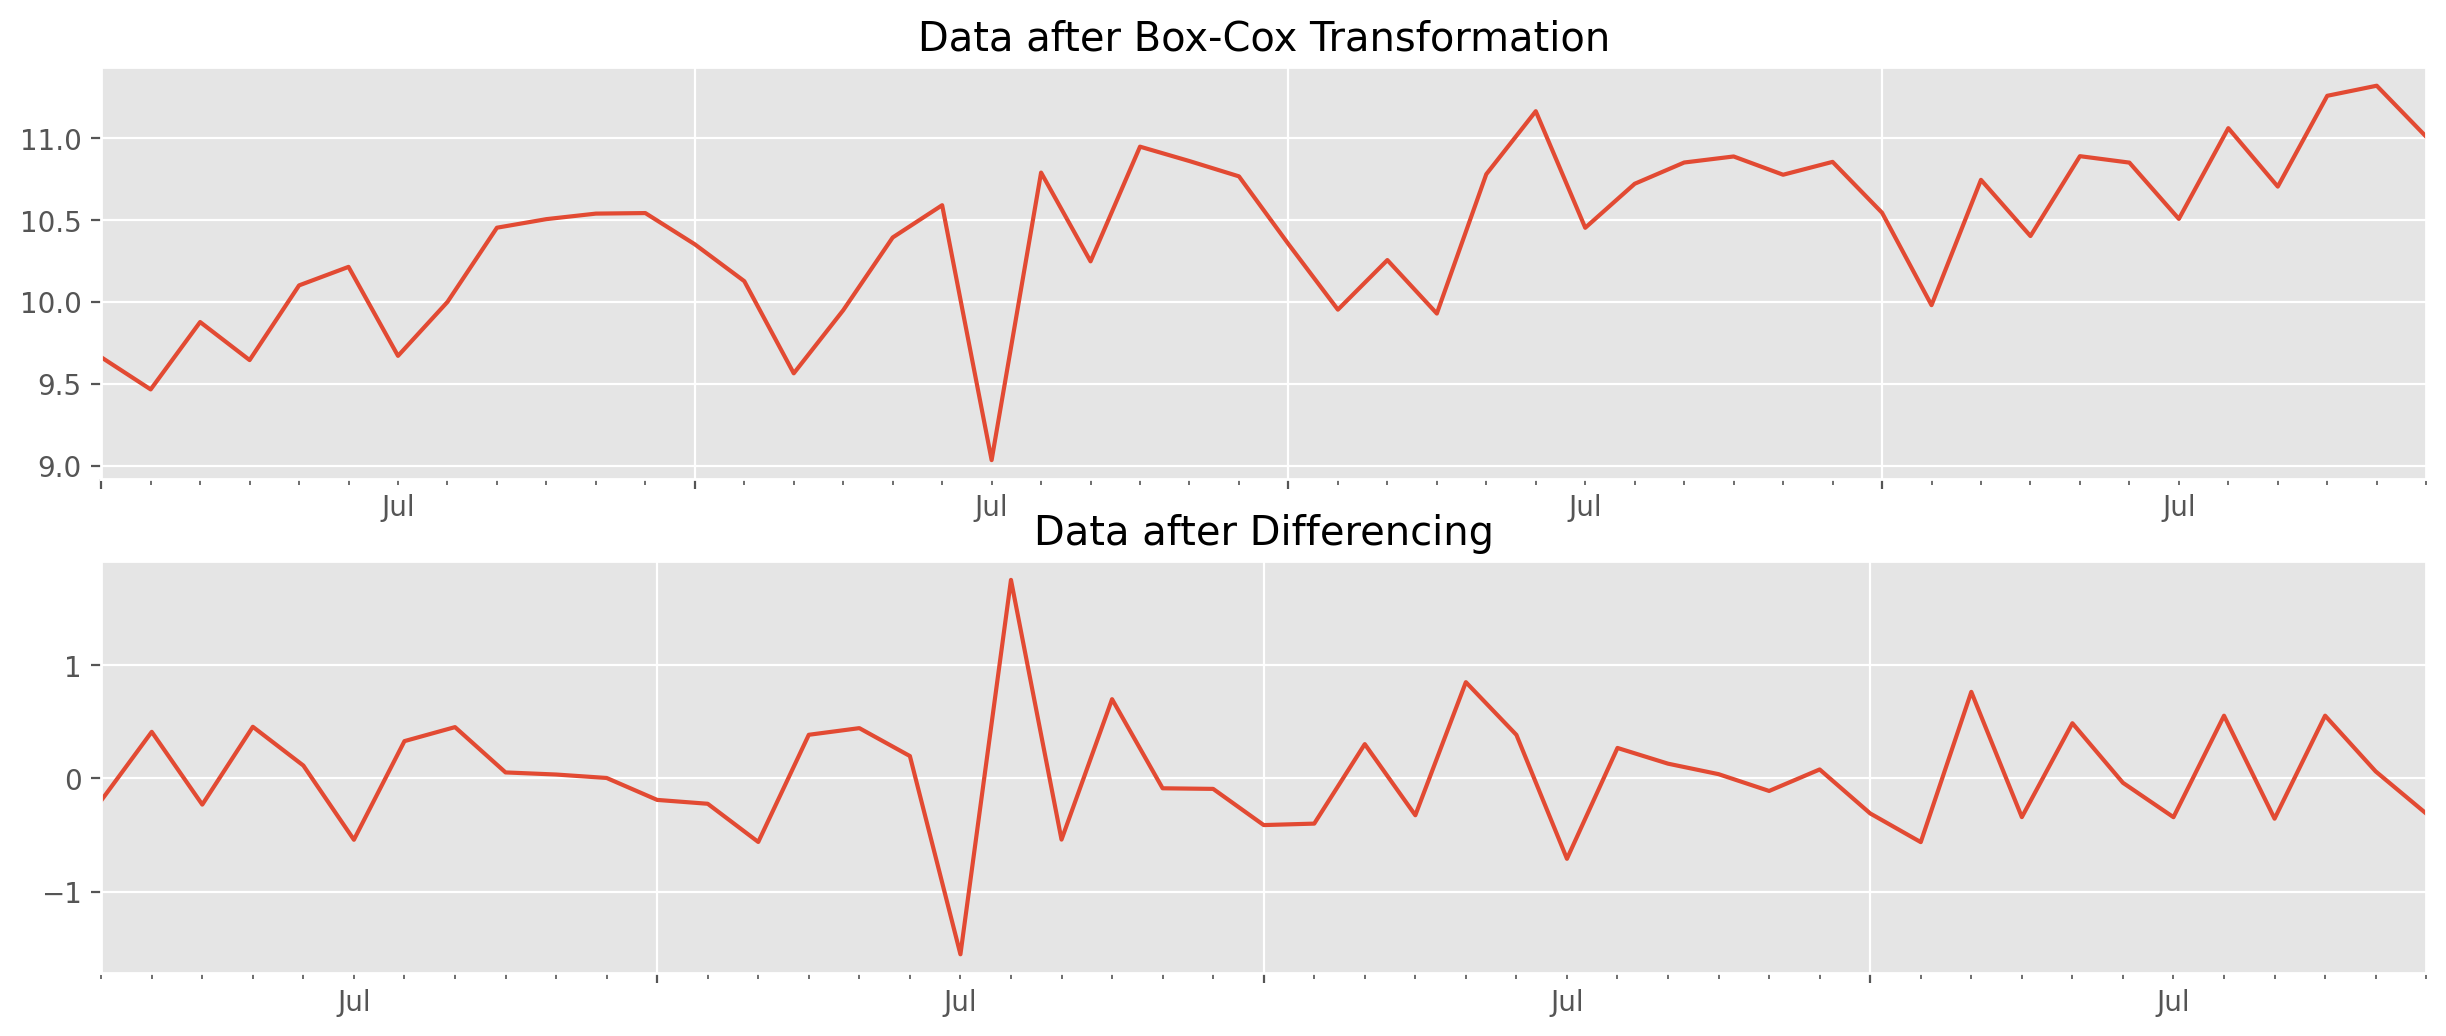

In [42]:
fig, ax = plt.subplots(2,figsize=(15,6),dpi=200)

data_boxcox.plot(ax=ax[0])
ax[0].set_xlabel("")
ax[0].set_title("Data after Box-Cox Transformation")
ax[0].set_xticklabels([])

data_boxcox_diff.plot(ax=ax[1])
ax[1].set_xlabel("")
ax[1].set_title("Data after Differencing")
ax[1].set_xticklabels([])

fig.show()

**<span style = "color:green">Hence, from the above results we can conclude that Box-Cox Transformation and Differencing have made the data stationary.</span>**

**Splitting the data into train and test**

In [43]:
train_boxcox = data_boxcox[:train.index.max()]
test_boxcox = data_boxcox[test.index.min():]

In [44]:
train_boxcox_diff = data_boxcox_diff[:train.index.max()]
test_boxcox_diff = data_boxcox_diff[test.index.min():]

**Performing ADF and KPSS tests on the transformed data**

In [45]:
adf_test = adfuller(data_boxcox_diff)

print(f"ADF Statistic: {round(adf_test[0],3)}")
print(f"Critical Values @ 0.05: {round(adf_test[4]['5%'],3)}")
print(f"p-value: {round(adf_test[1],3)}")

ADF Statistic: -5.769
Critical Values @ 0.05: -2.946
p-value: 0.0


**<span style = "color:green">From the above results, we `reject` the `Null Hypothesis`, i.e., we `reject` that the `data is not stationary`.</span>**

In [46]:
kpss_test = kpss(data_boxcox_diff)

print(f"KPSS Statistic: {round(kpss_test[0],3)}")
print(f"Critical Values @ 0.05: {round(kpss_test[3]['5%'],3)}")
print(f"p-value: {round(kpss_test[1],3)}")

KPSS Statistic: 0.136
Critical Values @ 0.05: 0.463
p-value: 0.1


**<span style = "color:green">From the above results, we `fail to reject` the `Null Hypothesis`, i.e., we `fail to reject` that the `data is stationary`.</span>**

### Forecasting using Auto Regressive (AR) Model

**Fitting the model**

In [47]:
ar_model = ARIMA(train_boxcox_diff,order=(1,0,0)) 
ar_model_fit = ar_model.fit()

print(ar_model_fit.params.round(4))

const      0.0313
ar.L1.y   -0.4840
dtype: float64


**Getting the forecast**

In [48]:
forecast["Auto Regressive (AR)"] = recover_forecast(ar_model_fit)

**Computing MAPE**

In [49]:
get_mape(forecast)

                                                       MAPE
Simple Exponential Smoothing                          27.73
Holt's Exponential Smoothing                          25.01
Holt Winters' Exponential Smoothing - Additive        17.61
Holt Winters' Exponential Smoothing - Multiplicative  13.84
Auto Regressive (AR)                                  28.22


**Plotting the forecast**

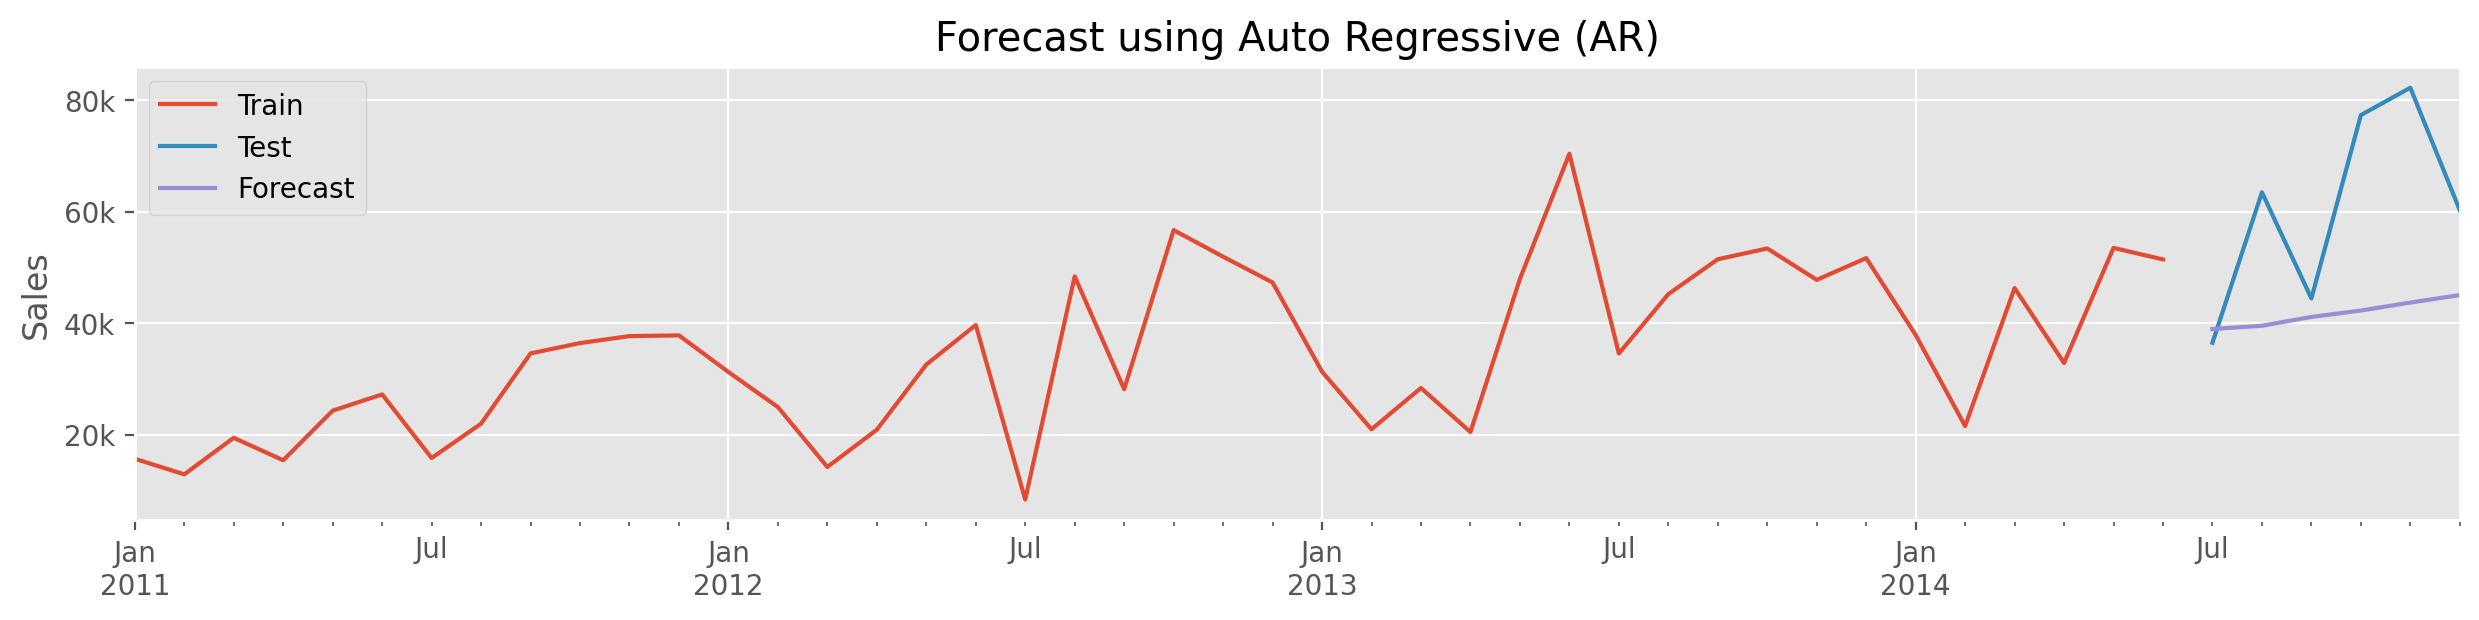

In [50]:
plot_forecast(forecast["Auto Regressive (AR)"],"Auto Regressive (AR)")

**<span style = "color:green">From the above plot, we can observe that the model has captured only the trend. Also, compared to the MAPE results achieved from the Exponential models, this model has not performed so well. Hence, this is not a suitable method to be used to forecast the sales for the selected market segment.</span>**

### Forecasting using Moving Average (MA) Model

**Fitting the model**

In [51]:
ma_model = ARIMA(train_boxcox_diff,order=(0,0,1)) 
ma_model_fit = ma_model.fit()

print(ma_model_fit.params)

const      0.022694
ma.L1.y   -1.000000
dtype: float64


**Getting the forecast**

In [52]:
forecast["Moving Average (MA)"] = recover_forecast(ma_model_fit)

**Computing MAPE**

In [53]:
get_mape(forecast)

                                                       MAPE
Simple Exponential Smoothing                          27.73
Holt's Exponential Smoothing                          25.01
Holt Winters' Exponential Smoothing - Additive        17.61
Holt Winters' Exponential Smoothing - Multiplicative  13.84
Auto Regressive (AR)                                  28.22
Moving Average (MA)                                   32.27


**Plotting the forecast**

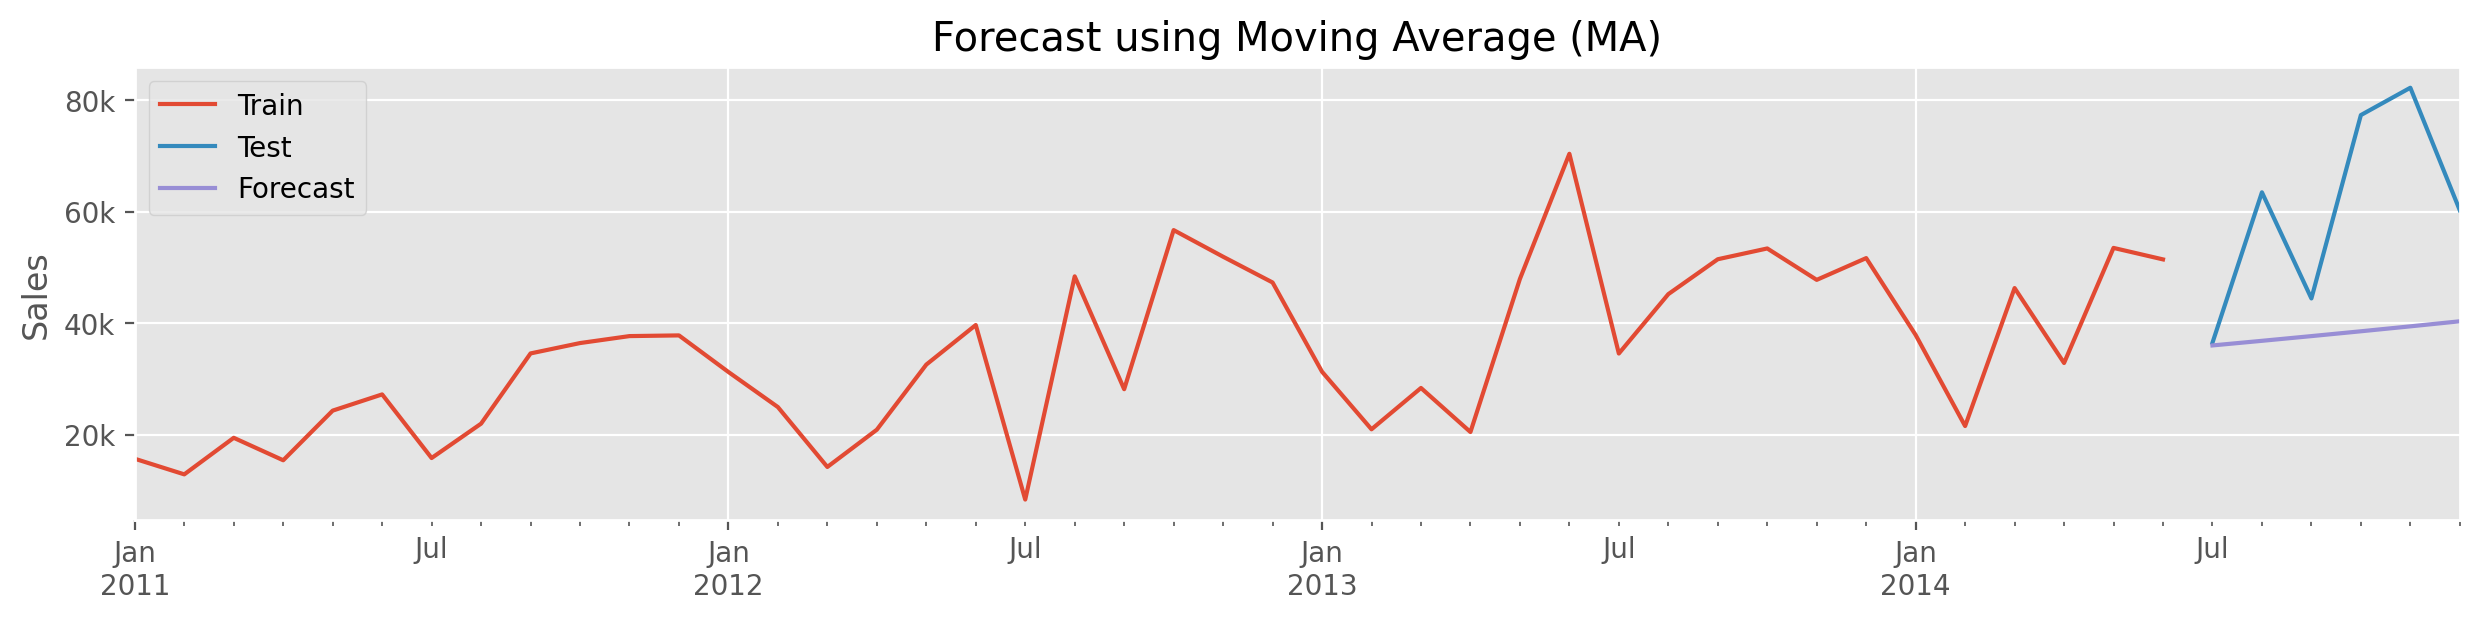

In [54]:
plot_forecast(forecast["Moving Average (MA)"],"Moving Average (MA)")

**<span style = "color:green">From the above plot, we can observe that the model has captured only the trend. Also, compared to the MAPE results achieved under AR model, the MAPE score is even worse. Hence, this is not a suitable method to be used to forecast the sales for the selected market segment.</span>**

### Forecasting using Auto Regressive Moving Average (ARMA) Model

**Fitting the model**

In [55]:
arma_model = ARIMA(train_boxcox_diff, order=(1,0,1))
arma_model_fit = arma_model.fit()

print(arma_model_fit.params)

const      0.022810
ar.L1.y    0.115928
ma.L1.y   -0.999945
dtype: float64


**Getting the forecast**

In [56]:
forecast["Auto Regressive Moving Average (ARMA)"] = recover_forecast(arma_model_fit)

**Computing MAPE**

In [57]:
get_mape(forecast)

                                                       MAPE
Simple Exponential Smoothing                          27.73
Holt's Exponential Smoothing                          25.01
Holt Winters' Exponential Smoothing - Additive        17.61
Holt Winters' Exponential Smoothing - Multiplicative  13.84
Auto Regressive (AR)                                  28.22
Moving Average (MA)                                   32.27
Auto Regressive Moving Average (ARMA)                 32.04


**Plotting the forecast**

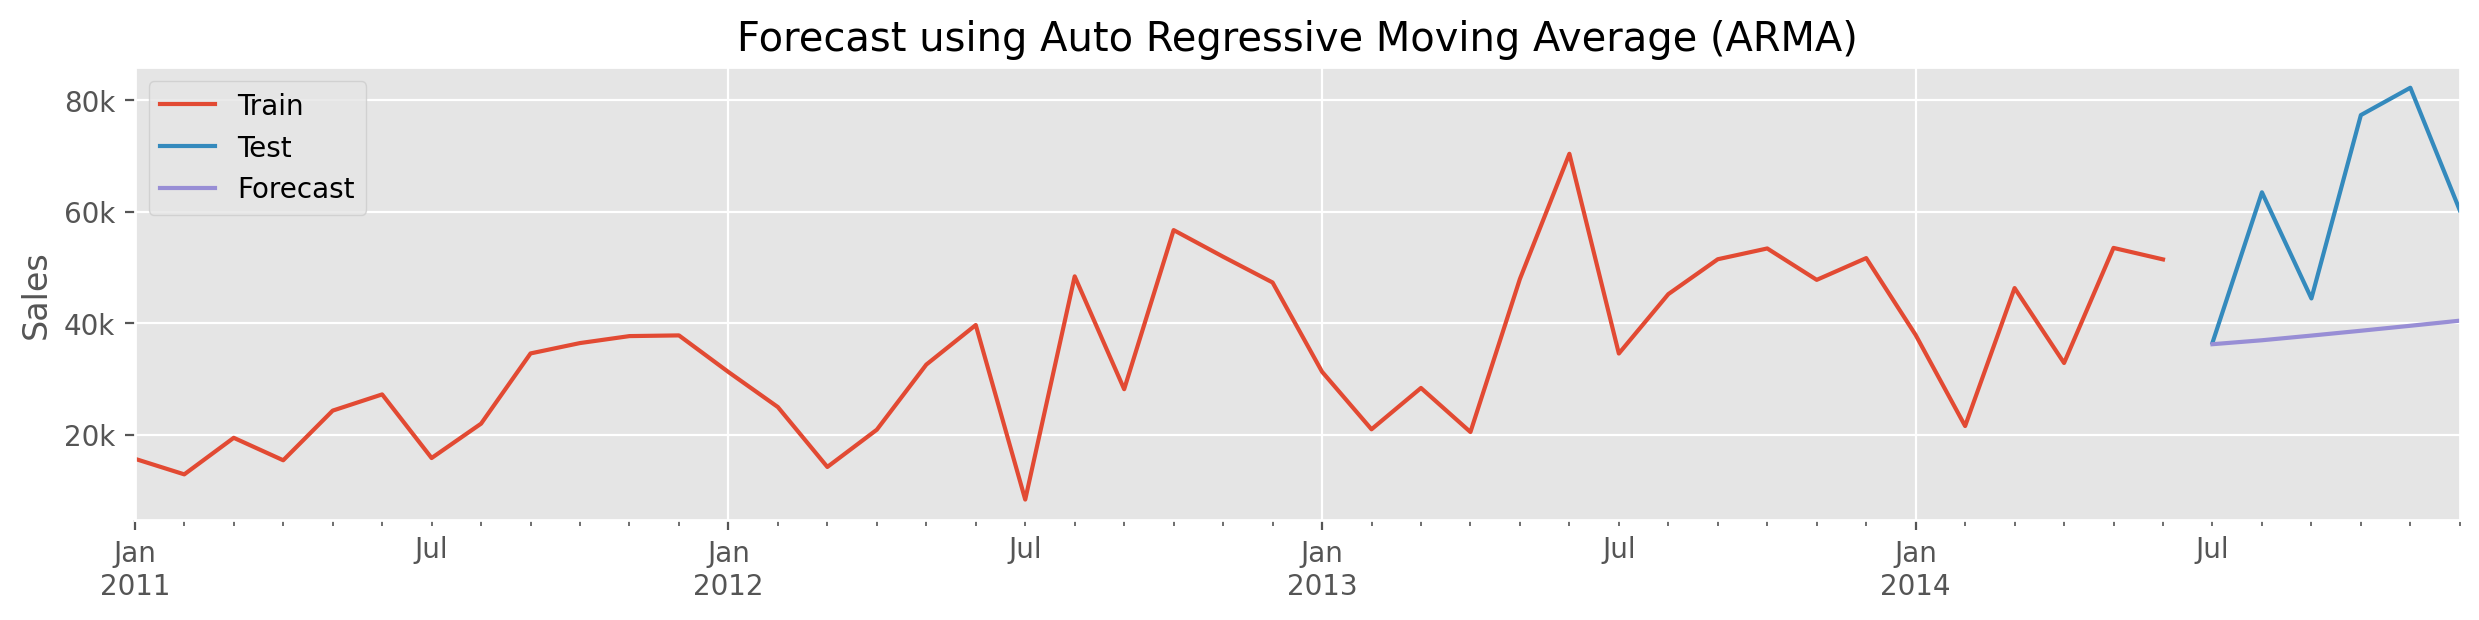

In [58]:
plot_forecast(forecast["Auto Regressive Moving Average (ARMA)"],
              "Auto Regressive Moving Average (ARMA)")

**<span style = "color:green">From the above plot, we can observe that the model has captured only the trend. Also, compared to the MAPE results achieved under MA model, there is not much improvement. Hence, this is not a suitable method to be used to forecast the sales for the selected market segment.</span>**

### Forecasting using Auto Regressive Integrated Moving Average (ARIMA) Model

**Fitting the model**

In [59]:
arima_model = ARIMA(train_boxcox,order=(1,1,1))
arima_model_fit = arima_model.fit()

print(arima_model_fit.params)

const        0.022810
ar.L1.D.y    0.115928
ma.L1.D.y   -0.999945
dtype: float64


**Getting the forecast**

In [60]:
forecast["Auto Regressive Integrated Moving Average (ARIMA)"] = recover_forecast(arima_model_fit)

**Computing MAPE**

In [61]:
get_mape(forecast)

                                                       MAPE
Simple Exponential Smoothing                          27.73
Holt's Exponential Smoothing                          25.01
Holt Winters' Exponential Smoothing - Additive        17.61
Holt Winters' Exponential Smoothing - Multiplicative  13.84
Auto Regressive (AR)                                  28.22
Moving Average (MA)                                   32.27
Auto Regressive Moving Average (ARMA)                 32.04
Auto Regressive Integrated Moving Average (ARIMA)     32.04


**Plotting the forecast**

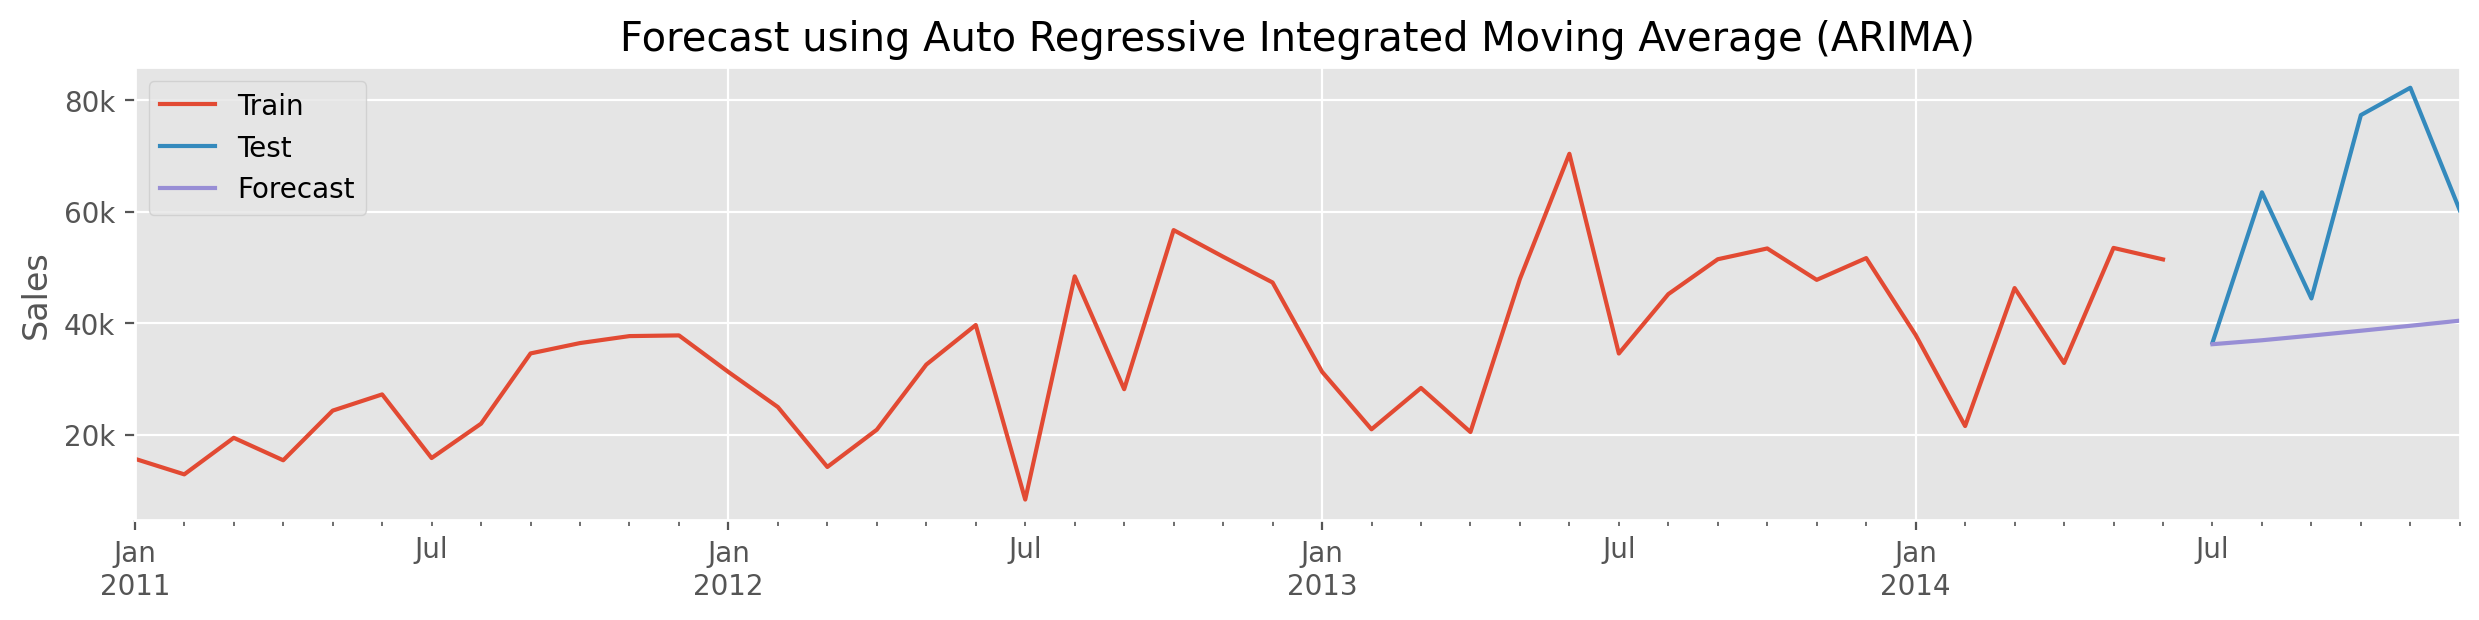

In [62]:
plot_forecast(forecast["Auto Regressive Integrated Moving Average (ARIMA)"],
              "Auto Regressive Integrated Moving Average (ARIMA)")

**<span style = "color:green">From the above plot, we can observe that the model has captured only the trend. Also, the MAPE scores of both ARMA and ARIMA are same since we have taken only first order differening in the current model.</span>**

### Forecasting using Seasonal Auto Regressive Integrated Moving Average (SARIMA) Model

**Fitting the model**

In [63]:
sarima_model = SARIMAX(train_boxcox,order=(1,1,1),seasonal_order=(1,1,1,12)) 
sarima_model_fit = sarima_model.fit()

print(sarima_model_fit.params)

ar.L1      -0.100508
ma.L1      -0.994302
ar.S.L12   -0.395196
ma.S.L12   -0.985737
sigma2      0.047436
dtype: float64


**Getting the forecast**

In [64]:
sarima_forecast_boxcox = sarima_model_fit.predict(test.index.min(),test.index.max())
forecast["Seasonal Auto Regressive Integrated Moving Average (SARIMA)"] = np.exp(sarima_forecast_boxcox)

**Computing MAPE**

In [65]:
get_mape(forecast)

                                                              MAPE
Simple Exponential Smoothing                                 27.73
Holt's Exponential Smoothing                                 25.01
Holt Winters' Exponential Smoothing - Additive               17.61
Holt Winters' Exponential Smoothing - Multiplicative         13.84
Auto Regressive (AR)                                         28.22
Moving Average (MA)                                          32.27
Auto Regressive Moving Average (ARMA)                        32.04
Auto Regressive Integrated Moving Average (ARIMA)            32.04
Seasonal Auto Regressive Integrated Moving Average (SARIMA)  18.38


**Plotting the forecast**

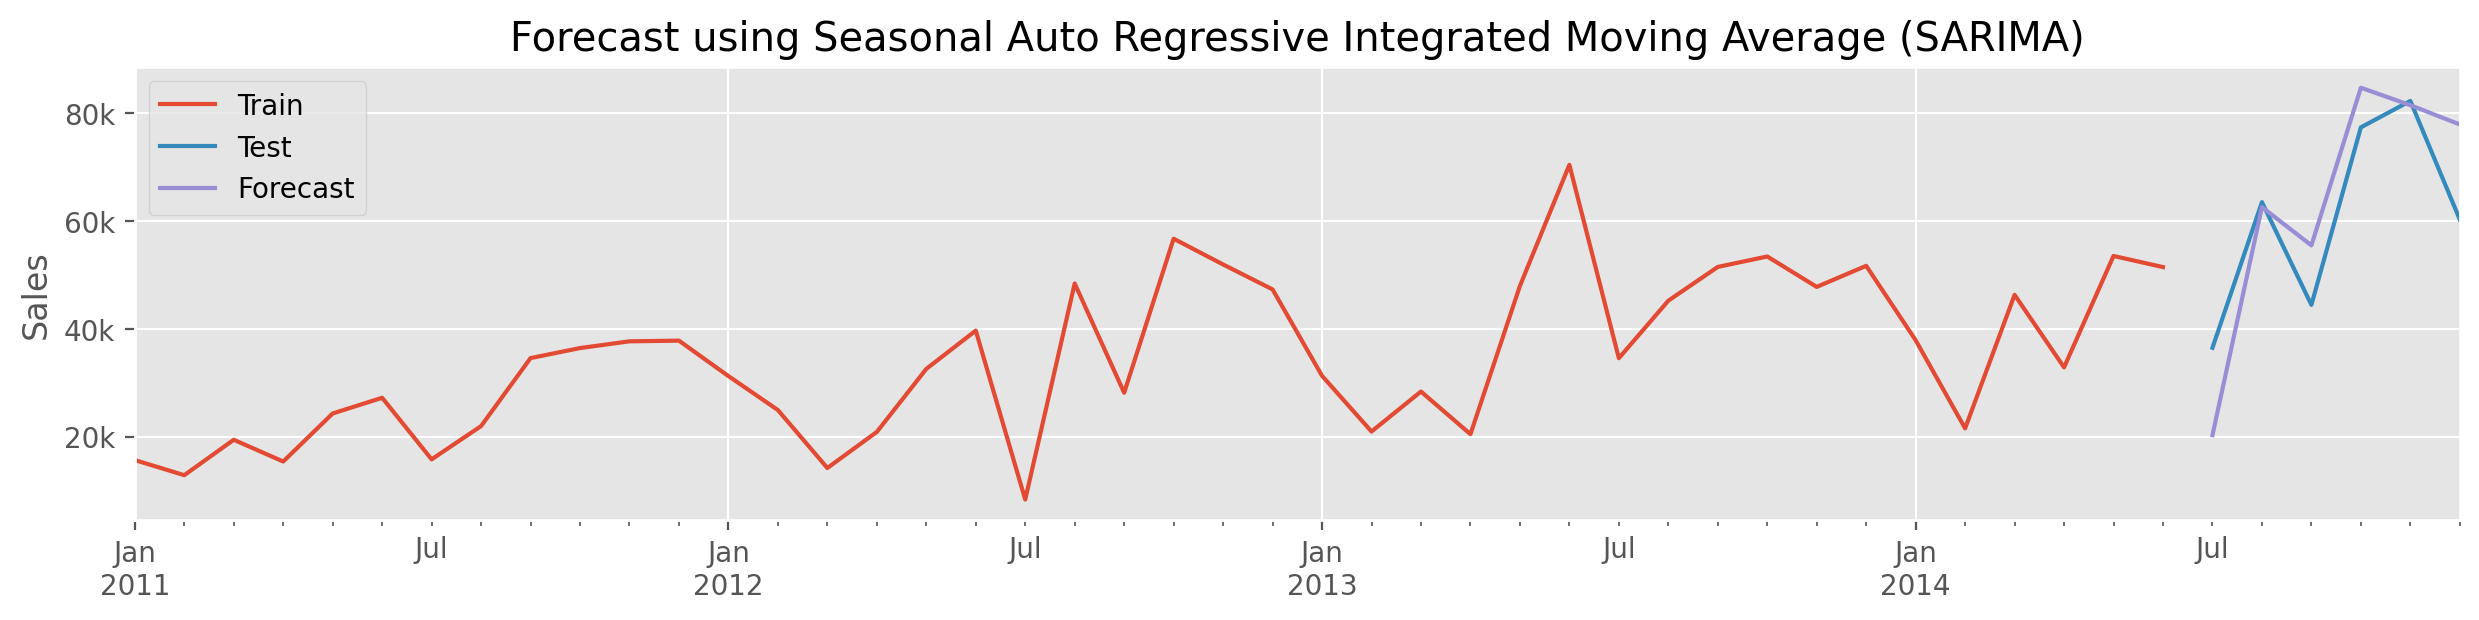

In [66]:
plot_forecast(forecast["Seasonal Auto Regressive Integrated Moving Average (SARIMA)"],
              "Seasonal Auto Regressive Integrated Moving Average (SARIMA)")

**<span style = "color:green">From the above plot, we can observe that the model has very well captured both trend and seasonality. Also, MAPE results are the least compared to the earlier ARIMA models. Hence, this would the best model to be used for the forecast under the ARIMA models.</span>**

## Conclusion

**<span style = "color:green">Upon comparing both `Holt Winters' Exponential Smoothing using Multiplicative Method` and `Seasonal Auto Regressive Integrated Moving Average (SARIMA)` models, we can prefer `Holt Winters' Exponential Smoothing using Multiplicative Method` for forecasting since the it has an MAPE of `13.84` compared to `Seasonal Auto Regressive Integrated Moving Average (SARIMA)` having an MAPE of `18.38`.**</span>

**<span style = "color:green">Hence, the final model to be used for forecast is `Holt Winters' Exponential Smoothing using Multiplicative Method`.**</span>

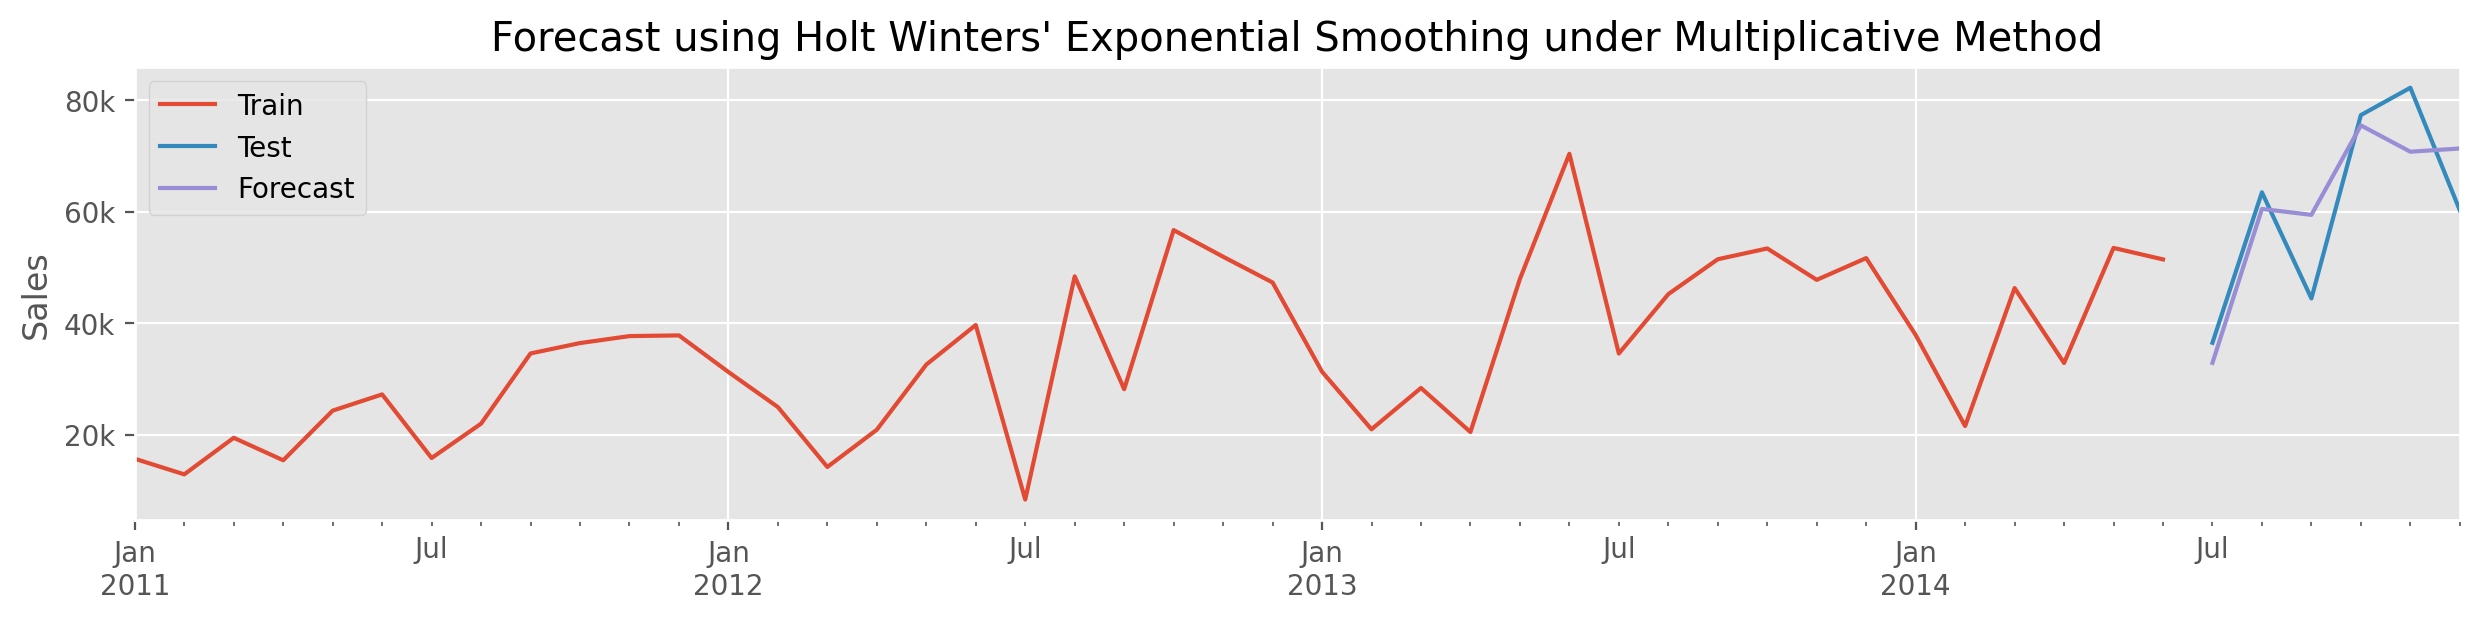

In [67]:
plot_forecast(forecast["Holt Winters' Exponential Smoothing - Multiplicative"],
              "Holt Winters' Exponential Smoothing under Multiplicative Method")